In [1]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, LSTM, Dense
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler


In [2]:
data_path = 'date_data.csv'
df = pd.read_csv(data_path)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1426 entries, 0 to 1425
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   dt                     1426 non-null   object 
 1   Global_active_power    1426 non-null   float64
 2   Global_reactive_power  1426 non-null   float64
 3   Voltage                1426 non-null   float64
 4   Global_intensity       1426 non-null   float64
 5   Sub_metering_1         1426 non-null   float64
 6   Sub_metering_2         1426 non-null   float64
 7   Sub_metering_3         1426 non-null   float64
 8   power_consumption      1426 non-null   float64
dtypes: float64(8), object(1)
memory usage: 100.4+ KB


In [4]:
df_full = df.copy()

In [5]:
df['dt'] = pd.to_datetime(df['dt'], format="%Y-%m-%d")

In [6]:
df = df.drop(columns=['dt'])

In [7]:
def df_to_X_y(df, window_size):
    df_as_np = df['power_consumption'].to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np) - window_size):
        row = [[a] for a in df_as_np[i:i+window_size]]
        X.append(row)
        label = df_as_np[i + window_size]
        y.append(label)
    return np.array(X), np.array(y)

In [8]:
WINDOW_SIZE = 3
X, y = df_to_X_y(df, WINDOW_SIZE)

In [9]:
X.shape, y.shape

((1423, 3, 1), (1423,))

In [10]:
split_1 = int(0.75 * len(df))
split_2 = int(0.9 * len(df))
X_train, y_train = X[:split_1], y[:split_1]
X_val, y_val = X[split_1:split_2], y[split_1:split_2]
X_test, y_test = X[split_2:], y[split_2:]

In [11]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(1069, 3, 1)
(1069,)
(214, 3, 1)
(214,)
(140, 3, 1)
(140,)


In [12]:
model = Sequential()
model.add(InputLayer((WINDOW_SIZE, 1)))
model.add(LSTM(128, return_sequences=True))  # Return sequences
model.add(LSTM(64))
model.add(Dropout(0.5))
model.add(Dense(1))

In [13]:
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 3, 128)         │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 116,033 (453.25 KB)

 Trainable params: 116,033 (453.25 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [15]:
cp = ModelCheckpoint('best_model.keras', save_best_only=True)

In [16]:
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, callbacks=[cp])

Epoch 1/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 111.1188 - root_mean_squared_error: 10.5390 - val_loss: 78.8111 - val_root_mean_squared_error: 8.8776
Epoch 2/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 89.3800 - root_mean_squared_error: 9.4529 - val_loss: 62.4481 - val_root_mean_squared_error: 7.9024
Epoch 3/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 74.8079 - root_mean_squared_error: 8.6469 - val_loss: 40.8627 - val_root_mean_squared_error: 6.3924
Epoch 4/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 49.0814 - root_mean_squared_error: 7.0030 - val_loss: 19.8892 - val_root_mean_squared_error: 4.4597
Epoch 5/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 31.4897 - root_mean_squared_error: 5.6001 - val_loss: 8.6293 - val_root_mean_squared_error: 2.9376
Epoch 6/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 20.6947 - root_mean_squared_error: 4.5430 - val_loss: 5.2722 - val_root_mean_squared_error: 2.2961
Epoch 7/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/ste

In [17]:
model = tf.keras.models.load_model('best_model.keras')

In [18]:
train_predictions = model.predict(X_train).flatten()
val_predictions = model.predict(X_val).flatten()
test_predictions = model.predict(X_test).flatten()


34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [19]:
train_results = pd.DataFrame(data={'Train Predictions': train_predictions, 'Actuals': y_train})
train_results

,Train Predictions,Actuals
0,10.465937,24.152454
1,11.967840,24.832454
2,13.012870,12.308079
3,12.790293,12.374769
4,12.107678,13.431944
...,...,...
1064,11.668713,9.246157
1065,10.739738,12.414977
1066,11.296449,15.068773
1067,11.970934,14.023009


In [20]:
from sklearn.metrics import mean_absolute_error, mean_squared_error,r2_score

In [21]:
test_mae = mean_absolute_error(y_test, test_predictions)
test_mse = mean_squared_error(y_test, test_predictions)
test_r2 = r2_score(y_test, test_predictions)
test_rmse = np.sqrt(test_mse)

In [22]:
print(f"Test MAE: {test_mae}, Test MSE: {test_mse}, Test RMSE: {test_rmse}, Test R²: {test_r2}")


Test MAE: 1.645592439782221, Test MSE: 4.893148558509924, Test RMSE: 2.2120462378779346, Test R²: 0.5261891197957903


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


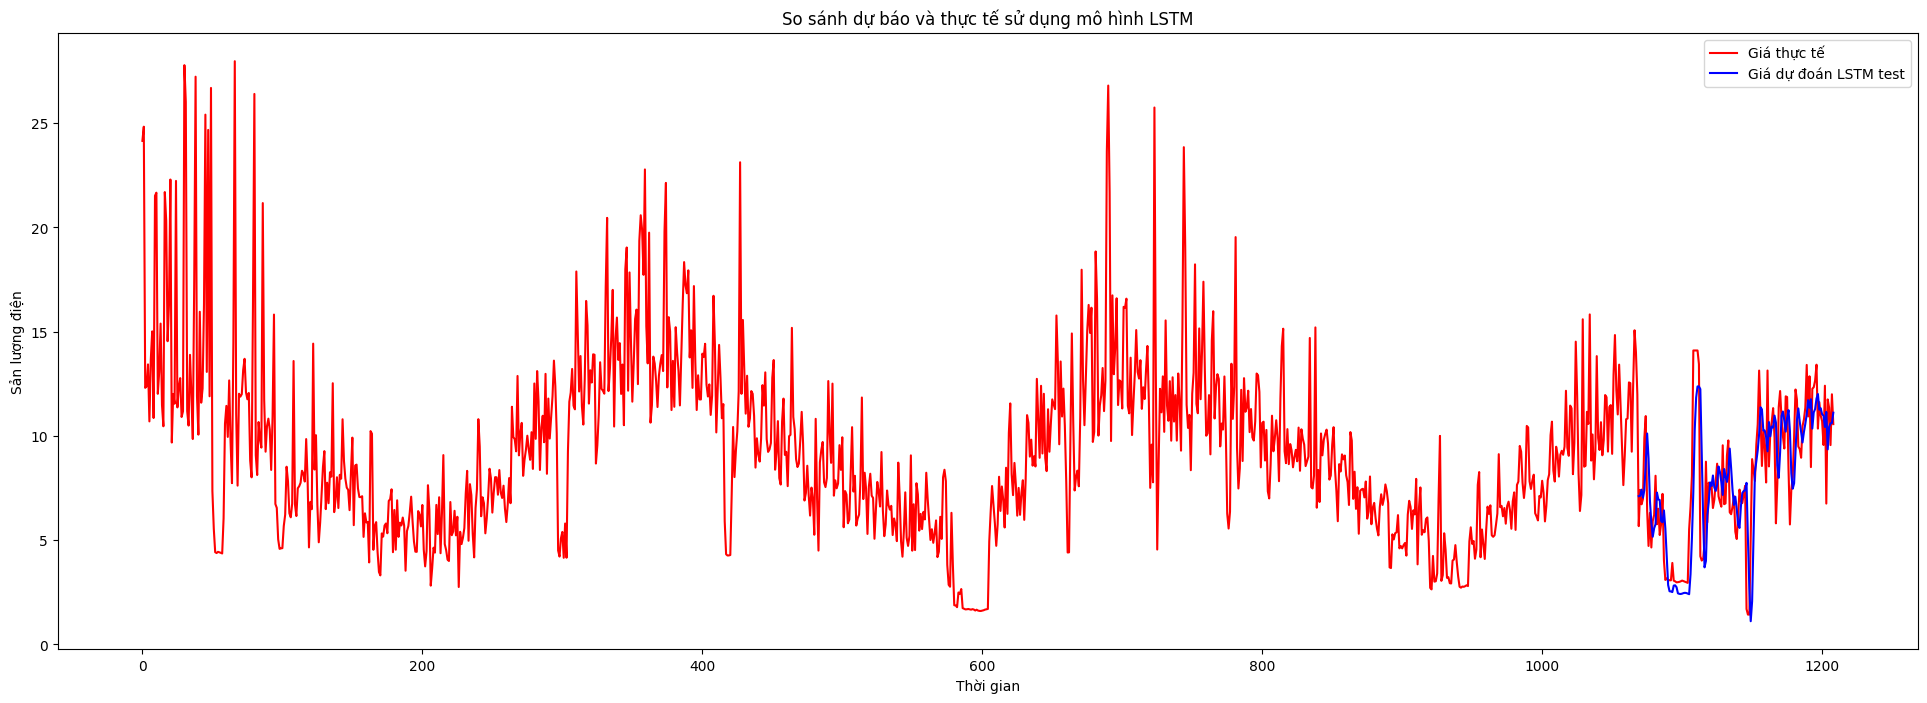

In [23]:
import matplotlib.pyplot as plt

# Dự đoán giá trị trên tập kiểm tra
lstm_test_pred = model.predict(X_test).flatten()

plt.figure(figsize=(24,8))

# Vẽ giá trị thực tế
plt.plot(np.concatenate([y_train, y_test]), label='Giá thực tế', color='red')

# Vẽ kết quả dự đoán từ mô hình LSTM trên tập kiểm tra
plt.plot(range(len(y_train), len(y_train) + len(y_test)), lstm_test_pred, label='Giá dự đoán LSTM test', color='blue')

plt.title('So sánh dự báo và thực tế sử dụng mô hình LSTM') # Đặt tên biểu đồ
plt.xlabel('Thời gian') # Đặt tên hàm x
plt.ylabel('Sản lượng điện') # Đặt tên hàm y
plt.legend() # Chú thích
plt.show()


In [24]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Dự đoán giá trị trên tập kiểm tra
lstm_test_pred = model.predict(X_test).flatten()

# Tính toán các độ đo
mae = mean_absolute_error(y_test, lstm_test_pred)
mse = mean_squared_error(y_test, lstm_test_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, lstm_test_pred)

# In ra các độ đo
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Mean Absolute Error (MAE): 1.645592439782221
Mean Squared Error (MSE): 4.893148558509924
Root Mean Squared Error (RMSE): 2.2120462378779346


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


C:\Users\Alone\AppData\Local\Temp\ipykernel_9324\975435851.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  last_input[0, -1] = next_pred


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


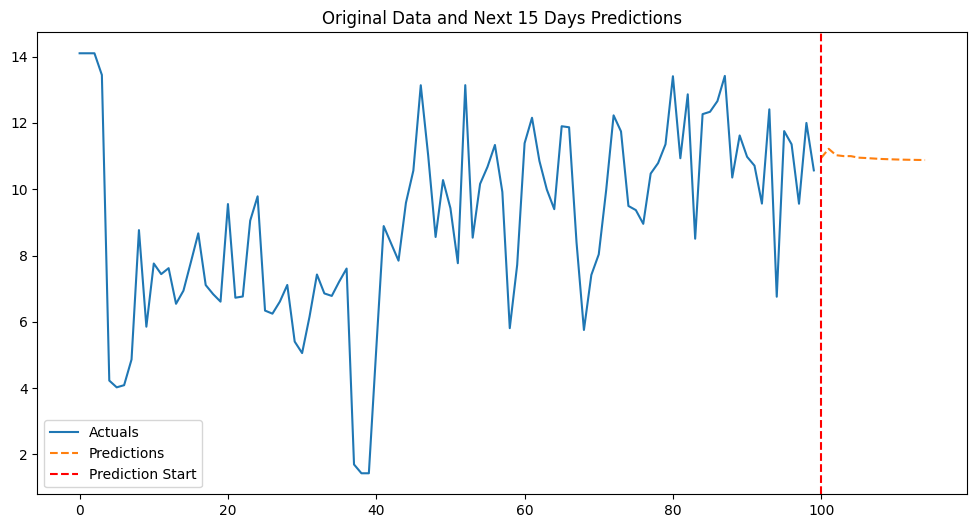

In [33]:
# Sử dụng phần cuối của dữ liệu ban đầu
last_input = X[-1]
predictions_15_days = []

for _ in range(15):
    next_pred = model.predict(last_input.reshape((1, WINDOW_SIZE, 1)))
    predictions_15_days.append(next_pred[0, 0])
    
    # Cập nhật đầu vào cho lần dự đoán tiếp theo
    last_input = np.roll(last_input, -1)
    last_input[0, -1] = next_pred

# Tạo chuỗi mở rộng để vẽ biểu đồ
extended_actuals = np.concatenate((y[-100:], [np.nan]*15))
extended_predictions = np.concatenate((y[-100:], predictions_15_days))

# Vẽ biểu đồ dữ liệu thực tế với dự đoán 15 ngày được nối vào
plt.figure(figsize=(12, 6))
plt.plot(range(len(extended_actuals)), extended_actuals, label='Actuals')
plt.plot(range(len(y[-100:]), len(y[-100:]) + 15), predictions_15_days, label='Predictions', linestyle='--')
plt.axvline(x=len(y[-100:]), color='r', linestyle='--', label='Prediction Start')
plt.legend()
plt.title('Original Data and Next 15 Days Predictions')
plt.show()


In [26]:
from tensorflow.keras.layers import LSTM, GRU

# Khởi tạo mô hình
modelLSTMGRU = Sequential()

# Thêm lớp đầu vào
modelLSTMGRU.add(InputLayer((WINDOW_SIZE, 1)))

# Thêm lớp LSTM với return_sequences=True để trả về đầu ra ở mỗi bước thời gian
modelLSTMGRU.add(LSTM(128, return_sequences=True))

# Thêm lớp GRU
modelLSTMGRU.add(GRU(64))

# Thêm lớp Dropout
modelLSTMGRU.add(Dropout(0.5))

# Thêm lớp Dense cuối cùng
modelLSTMGRU.add(Dense(1))

# Biên dịch mô hình
modelLSTMGRU.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

# Huấn luyện mô hình, sử dụng tập validation
cp = ModelCheckpoint('best_model_lstm_gru.keras', save_best_only=True)
modelLSTMGRU.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, callbacks=[cp])

# Load mô hình tốt nhất
modelLSTMGRU = tf.keras.models.load_model('best_model_lstm_gru.keras')


Epoch 1/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - loss: 104.0255 - root_mean_squared_error: 10.1825 - val_loss: 64.8988 - val_root_mean_squared_error: 8.0560
Epoch 2/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 75.7540 - root_mean_squared_error: 8.7005 - val_loss: 44.9604 - val_root_mean_squared_error: 6.7053
Epoch 3/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 53.3162 - root_mean_squared_error: 7.3010 - val_loss: 24.0728 - val_root_mean_squared_error: 4.9064
Epoch 4/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 35.0037 - root_mean_squared_error: 5.9098 - val_loss: 9.5033 - val_root_mean_squared_error: 3.0827
Epoch 5/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 18.7706 - root_mean_squared_error: 4.3250 - val_loss: 5.0624 - val_root_mean_squared_error: 2.2500
Epoch 6/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 13.8708 - root_mean_squared_error: 3.7126 - val_loss: 4.6205 - val_root_mean_squared_error: 2.1495
Epoch 7/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7m

In [27]:
modelLSTMGRU.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 3, 128)         │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 64)             │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 311,621 (1.19 MB)

 Trainable params: 103,873 (405.75 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 207,748 (811.52 KB)

In [28]:
train_predictions = modelLSTMGRU.predict(X_train).flatten()
val_predictions = modelLSTMGRU.predict(X_val).flatten()
test_predictions = modelLSTMGRU.predict(X_test).flatten()

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


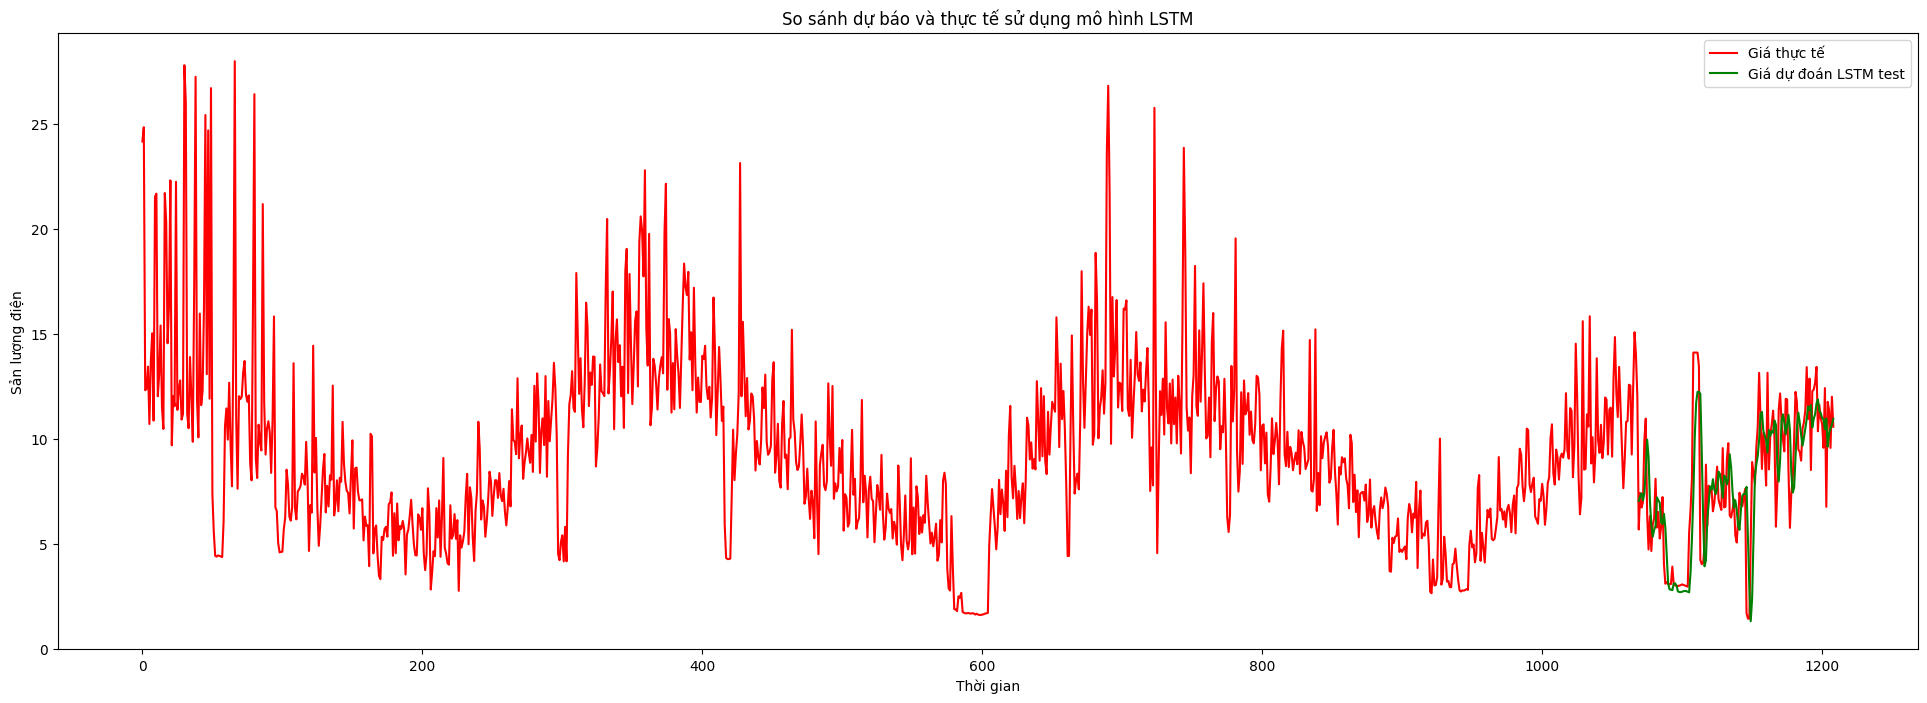

In [29]:
import matplotlib.pyplot as plt

# Dự đoán giá trị trên tập kiểm tra
lstm_test_pred = modelLSTMGRU.predict(X_test).flatten()

plt.figure(figsize=(24,8))

# Vẽ giá trị thực tế
plt.plot(np.concatenate([y_train, y_test]), label='Giá thực tế', color='red')

# Vẽ kết quả dự đoán từ mô hình LSTM trên tập kiểm tra
plt.plot(range(len(y_train), len(y_train) + len(y_test)), lstm_test_pred, label='Giá dự đoán LSTM test', color='green')

plt.title('So sánh dự báo và thực tế sử dụng mô hình LSTM') # Đặt tên biểu đồ
plt.xlabel('Thời gian') # Đặt tên hàm x
plt.ylabel('Sản lượng điện') # Đặt tên hàm y
plt.legend() # Chú thích
plt.show()


In [30]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Dự đoán giá trị trên tập kiểm tra
lstm_test_pred = modelLSTMGRU.predict(X_test).flatten()

# Tính toán các độ đo
mae = mean_absolute_error(y_test, lstm_test_pred)
mse = mean_squared_error(y_test, lstm_test_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, lstm_test_pred)

# In ra các độ đo
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Mean Absolute Error (MAE): 1.6201232416965776
Mean Squared Error (MSE): 4.858102513542139
Root Mean Squared Error (RMSE): 2.2041103678223872


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


C:\Users\Alone\AppData\Local\Temp\ipykernel_9324\1065693443.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  last_input[0, -1] = next_pred


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


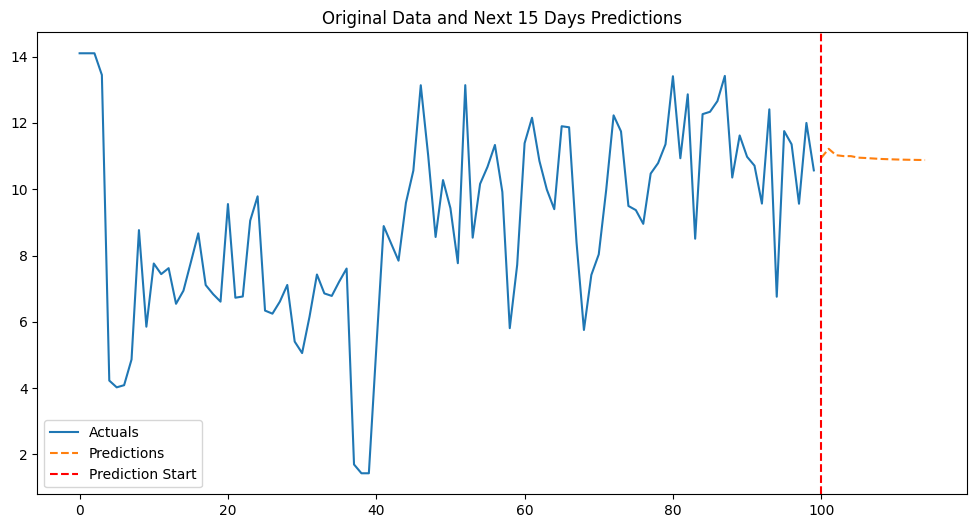

In [31]:
# Sử dụng phần cuối của dữ liệu ban đầu
last_input = X[-1]
predictions_15_days = []

for _ in range(15):
    next_pred = modelLSTMGRU.predict(last_input.reshape((1, WINDOW_SIZE, 1)))
    predictions_15_days.append(next_pred[0, 0])
    
    # Cập nhật đầu vào cho lần dự đoán tiếp theo
    last_input = np.roll(last_input, -1)
    last_input[0, -1] = next_pred

# Tạo chuỗi mở rộng để vẽ biểu đồ
extended_actuals = np.concatenate((y[-100:], [np.nan]*15))
extended_predictions = np.concatenate((y[-100:], predictions_15_days))

# Vẽ biểu đồ dữ liệu thực tế với dự đoán 15 ngày được nối vào
plt.figure(figsize=(12, 6))
plt.plot(range(len(extended_actuals)), extended_actuals, label='Actuals')
plt.plot(range(len(y[-100:]), len(y[-100:]) + 15), predictions_15_days, label='Predictions', linestyle='--')
plt.axvline(x=len(y[-100:]), color='r', linestyle='--', label='Prediction Start')
plt.legend()
plt.title('Original Data and Next 15 Days Predictions')
plt.show()


In [32]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

models = [model, modelLSTMGRU]
model_names = ['LSTM', 'LSTM+GRU']
metrics = []

for model in models:
    predictions = model.predict(X_test).flatten()
    mae = mean_absolute_error(y_test, predictions)
    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)
    metrics.append([mae, mse, rmse])

# Tạo DataFrame để hiển thị kết quả
df_metrics = pd.DataFrame(metrics, columns=['MAE', 'MSE', 'RMSE'], index=model_names)
print(df_metrics)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
               MAE       MSE      RMSE
LSTM      1.645592  4.893149  2.212046
LSTM+GRU  1.620123  4.858103  2.204110
